# Autoencoder Implementation

To implement the autoencoder, we chose Pytorch for its similarity to numpy and compatibility to gpus.

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

### Test Matrix

Test Matrix below was used to debug and test the performance before applying it to the actual matrix.
The matrix is a sparse integer matrix of 100 users by 50 items.

In [110]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0

# Convert to PyTorch tensor
interaction_tensor = torch.tensor(interaction_matrix, dtype=torch.float32)

# Add noise to the input data
def add_noise(data, noise_factor=0.3):
    noisy_data = data + noise_factor * torch.randn_like(data)
    noisy_data = torch.clamp(noisy_data, 0., 5.)  # Ensure values stay within the interaction range
    return noisy_data

noisy_interaction_tensor = add_noise(interaction_tensor)

# Print the original and noisy matrices (first 10 users for brevity)
print("Original Interaction Matrix (first 10 users):")
print(interaction_matrix[:10])  # Print only the first 10 users for brevity
print("\nNoisy Interaction Matrix (first 10 users):")
print(noisy_interaction_tensor[:10].numpy())


Original Interaction Matrix (first 10 users):
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 4]
 [0 0 0 ... 0 0 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 [0 0 4 ... 1 0 0]]

Noisy Interaction Matrix (first 10 users):
[[3.5780747  0.44618523 0.27021518 ... 0.         0.19485128 0.02848756]
 [0.         4.805831   0.         ... 0.         0.         3.971974  ]
 [0.         0.12133284 0.6427789  ... 0.         0.         4.9596815 ]
 ...
 [0.16250879 0.08124392 0.19579445 ... 0.09819969 0.18892097 0.5638384 ]
 [0.         0.3908983  1.8214145  ... 0.         0.         0.        ]
 [0.07031945 0.         3.5793095  ... 0.51570594 0.         0.36294198]]


In [10]:
class AutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(AutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 64),
			nn.ReLU(),
			nn.Linear(64, 128),
			nn.ReLU(),
			nn.Linear(128, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		x = self.decoder(x)
		return x
	
	def fit(self, batches, n_epochs=100, min_delta=0.0001, lr=0.001, patience=10):
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		best_loss = float('inf')
		patience_counter = 0
		epoch_losses = []
		epochs = []

		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for batch in batches:
				batch = batch[0].to(self.device)  # Move batch to device
				optimizer.zero_grad()
				output = self.forward(batch)
				loss = criterion(output, batch)
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()
		
			epoch_loss /= len(batches)

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1

			if patience_counter >= patience:
				print(f"Early stopping at epoch {epoch+1} with loss {epoch_loss:.4f}")
				break
			epoch_losses.append(epoch_loss)
			epochs.append(epoch+1)
			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
		return epochs, epoch_losses


In [112]:
batch_size = 128 
train = TensorDataset(noisy_interaction_tensor)
batches = DataLoader(train, batch_size=batch_size, shuffle=True)

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [114]:
# Instantiate the Autoencoder model
input_dim = num_items
bottleneck_size = 64
model = AutoEncoder(input_dim, bottleneck_size, device=device).to(device)
model.fit(batches, n_epochs=1000, lr=0.001, patience=10)

Epoch [1/1000], Loss: 1.5313
Epoch [2/1000], Loss: 1.4812
Epoch [3/1000], Loss: 1.4615
Epoch [4/1000], Loss: 1.4445


KeyboardInterrupt: 

### Training the autoencoders

We then trained the model using Google Colab VM with nvidia's A100 gpu. 

In [ ]:
model = None

Note: `testing_mode` is a checkpoint variable to signify that we are testing the model on the local end. If set to false, it will train the model.

In [7]:
testing_mode = True

In [3]:
user_ratings = pd.read_csv('full_matrix.csv.gzip', compression='gzip', index_col=0)
user_ratings.notna().count().sum()
user_ratings = user_ratings.fillna(0)

In [5]:
user_ratings

,A101446I5AWY0Z,A103U0Q3IKSXHE,A103W7ZPKGOCC9,A105E427BB6J65,A106016KSI0YQ,A106E1N0ZQ4D9W,A1075MZNVRMSEO,A107C4RVRF0OP,A107YFBJ119GZR,A10872FHIJAKKD,...,AZVZSGHKV0AO0,AZWC9XAY34IPW,AZWG3PF80735Q,AZWOQXRCS1WA6,AZWW1U604W0N,AZXEZRXZQL1H2,AZXGPM8EKSHE9,AZXQKAMHK35PA,AZY8LGHVF8GMZ,AZZVZL4QEHEHO
1882931173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0826414346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0829814000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0595344550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0253338352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0590482467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0570047870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000OVF7JY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1402508735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After training on colab, we utilized the pytorch imports the weights and the model architecture into the 
model.

To see if there is a significant difference between bottlenecks, we decided to run it with different bottlenecks.

In [6]:
bottlenecks = [8, 16, 32, 64, 128]

For training, we used the batch size of 128 and parameters of 1000 epoch, learning rate of 0.001.

In [8]:
import os
if testing_mode:
	print('Tested')
# check if folder exists
elif os.path.isdir('models'):
	model = torch.load('amazon_model.pt')
	model.load_state_dict(torch.load('amazon_model_weights.pt'))
else:
	tensors = torch.tensor(user_ratings.to_numpy(), dtype=torch.float32, device=device)
	batch_size = 128
	for bottleneck in bottlenecks:
		model = AutoEncoder(input_dim, bottleneck, device=device).to(device)
		batches = DataLoader(TensorDataset(tensors), batch_size=batch_size, shuffle=True)
		epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=10)
		os.makedirs('models', exist_ok=True)
		os.makedirs('models/weights', exist_ok=True)
		os.makedirs('models/model', exist_ok=True)
		torch.save(model, f'models/model/model_k={bottleneck}.pt')
		torch.save(model.state_dict(), f'models/weights/model_weights_{bottleneck}.pt')


Tested


In [9]:
if not testing_mode:
	row = torch.tensor(user_ratings.iloc[0].to_numpy(), dtype=torch.float32, device=device)
	res , _ = mask_test_model(model, 0.2, row, user_ratings, device)
	res[res >= 0.1]

In [52]:
from numpy import linalg

In [53]:
# def test_sample_model(model: AutoEncoder, interaction_matrix: pd.DataFrame, device: torch.device, sample_size: int = 10):
# 	model.eval()
	
# 	sampled = interaction_matrix.sample(sample_size)
# 	display(sampled)
# 	tested = sampled.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device)[0], device), axis=0).to_numpy()
# 	# s = torch.tensor(sampled)
# 	return linalg.norm(sampled.to_numpy() - tested, ord='fro'), tested

In [10]:
def fit_by_bottleneck(user_ratings: pd.DataFrame, device: torch.device, bottleneck: int = 10):
	tensors = torch.tensor(user_ratings.to_numpy(), dtype=torch.float32, device=device)
	batch_size = 32 
	train = TensorDataset(tensors)
	batches = DataLoader(train, batch_size=batch_size, shuffle=True)
	model = AutoEncoder(user_ratings.shape[1], bottleneck)
	epochs, losses = model.fit(batches, n_epochs=1000, lr=0.001, patience=10)
	pd.DataFrame({"epochs": epochs, "training losses": losses}).to_csv(f'models/training_loss/{bottleneck}.csv')

	torch.save(model, f'models/model/model_k={bottleneck}.pt')
	torch.save(model.state_dict(), f'models/weights/model_weights_{bottleneck}.pt')

In [56]:

if not testing_mode:
	fit_by_bottleneck(user_ratings, device, 5)
	fit_by_bottleneck(user_ratings, device, 10)
	fit_by_bottleneck(user_ratings, device, 15)
	fit_by_bottleneck(user_ratings, device, 20)
	fit_by_bottleneck(user_ratings, device, 25)

## Model Performance 

Now, we can test the performance for each model

In [13]:
def mask_test_model(model: nn.Module, mask_fraction: float, row: torch.Tensor, device: torch.device):
    model.eval()
    with torch.no_grad():
        criterion = nn.MSELoss()
        
        # Identify non-zero elements in the row
        non_zero_indices = row.nonzero(as_tuple=True)[0]

        # Create a mask for the non-zero elements
        mask = torch.rand(len(non_zero_indices)).to(device) < mask_fraction

        # Apply the mask to the row
        masked_row = row.clone().to(device)
        masked_row[non_zero_indices[mask]] = 0

        # Get the model's predictions
        predictions = model(masked_row)

        # Calculate the loss only for the masked values
        loss = criterion(predictions[non_zero_indices[mask]], row[non_zero_indices[mask]])

        # Optionally, return the predictions and mask for further analysis
        return predictions.cpu().numpy(), mask.cpu().numpy()

In [11]:
def test_sample_model(model: AutoEncoder|DenoisingAutoEncoder, sample:pd.DataFrame, device: torch.device):
    model.eval()
    # sample = interaction_matrix.sample(sample_size, random_state=42)
    
    # Convert the sample DataFrame to a tensor
    sample_tensor = torch.tensor(sample.to_numpy(), dtype=torch.float32, device=device)
    
    # Test the model on each row of the sample
    # tested = sample.apply(lambda row: mask_test_model(model, 0.2, torch.tensor(row.to_numpy(), dtype=torch.float32, device=device), device)[0], axis=1)
    tested = []
    for row in sample.iterrows():
        prediction = mask_test_model(model, 0.2, torch.tensor(row[1].to_numpy(), dtype=torch.float32, device=device), device)[0]
        # display(prediction)
        prediction = pd.DataFrame(prediction)
        tested.append(prediction)
    

    tested = pd.concat(tested, axis=1)
    tested.index = sample.columns
    tested.columns = sample.index

    # Calculate the Frobenius norm of the difference
    # calculate the rmse
    
    # loss = linalg.norm(sample.to_numpy() - tested.to_numpy().T, ord='fro')
    mse = np.mean((sample.to_numpy() - tested.to_numpy().T)**2)
    loss = np.sqrt(mse)
    
    return loss, tested.T, sample

In [27]:
def test_bottleneck(user_ratings: pd.DataFrame, device: torch.device, sample, bottleneck: int = 10):
    print(f'Testing bottleneck {bottleneck}')
    model = torch.load(f'models/model/model_k={bottleneck}.pt')
    model.load_state_dict(torch.load(f'models/weights/model_weights_{bottleneck}.pt'))
    return test_sample_model(model, sample, device)

### Results

### Training Loss

In [20]:
import matplotlib.pyplot as plt
def plot_traing_loss(bottleneck: int):
	loss = pd.read_csv(f'models/training_loss/{bottleneck}.csv')
	plt.plot(loss['epochs'], loss['training losses'])
	plt.title(f'Training Loss for Bottleneck Size {bottleneck}')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	

For each bottleneck, we found the training loss as show below:

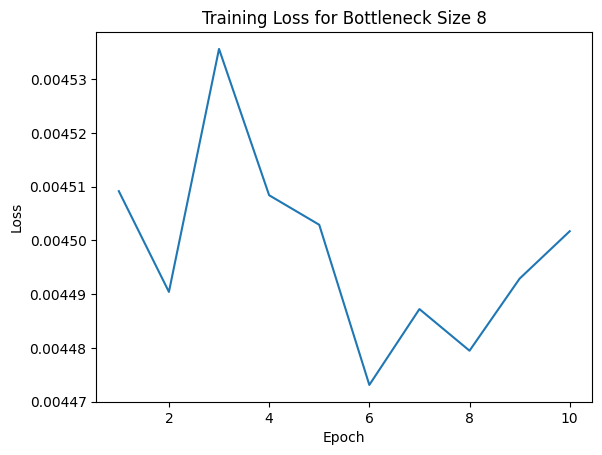

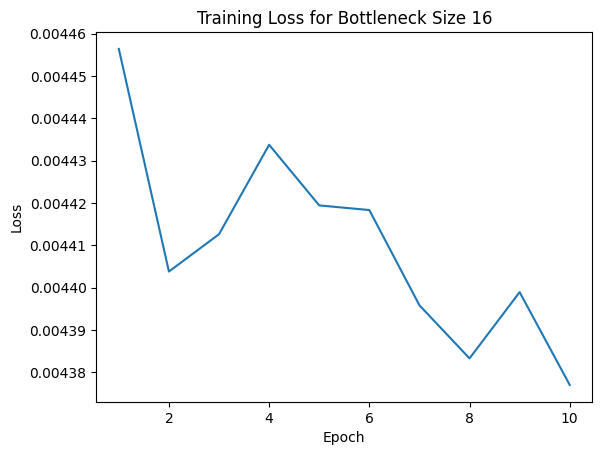

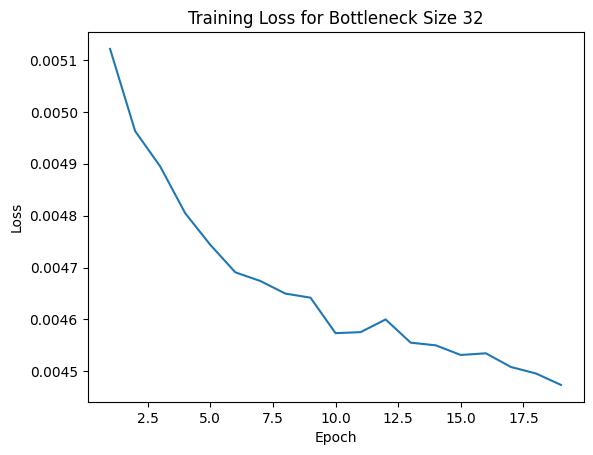

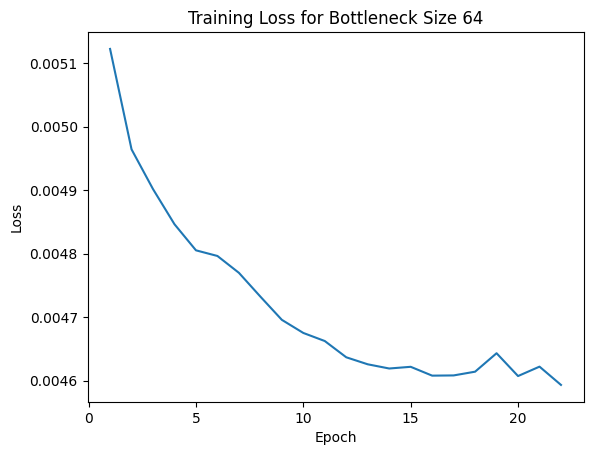

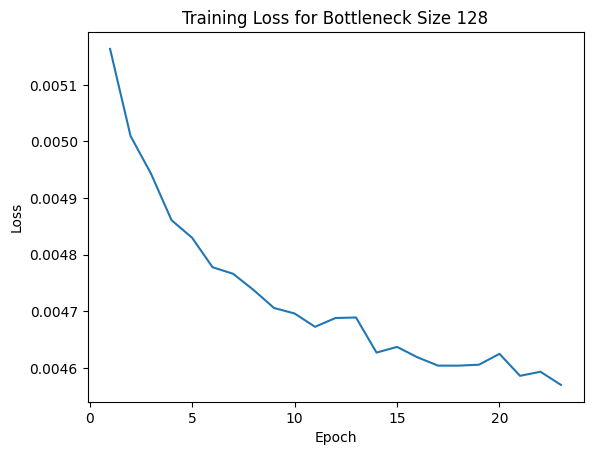

In [21]:
fig, ax = plt.subplots()
for bottleneck in bottlenecks:
	
	plot_traing_loss(bottleneck)
	plt.show()

### Performance

We took a sample of 100 books.

In [20]:
sample = user_ratings.sample(100)

We used the masking technique on the rows for each bottleneck.

In [28]:
bottleneck_results = [test_bottleneck(user_ratings, device, sample, k) for k in bottlenecks]
# bottleneck_results = test_bottleneck(user_ratings, device, 5)

Testing bottleneck 8
Testing bottleneck 16
Testing bottleneck 32
Testing bottleneck 64
Testing bottleneck 128


counted how many rows that match the original one. The resulting dataframe shows

In [38]:
performance_results = pd.DataFrame(columns=['RMSE', 'Non-Zero Count'])
for result in bottleneck_results:
	print(f'RMSE: {result[0]:.4f}')
	# display((result[1] > 0.1).sum().sum())
	performance_results = pd.concat([performance_results, pd.DataFrame({'RMSE': [result[0]], 'Non-Zero Count': [(result[1] >= 1).sum().sum()]})])

print("Non-zero count: ", (sample >= 1).sum().sum())
display(performance_results)

RMSE: 0.0531
RMSE: 0.0523
RMSE: 0.0518
RMSE: 0.0521
RMSE: 0.0522
Non-zero count:  115


/var/folders/rg/cmtcr_3n3g5bk2x49f7jdpdw0000gn/T/ipykernel_60862/3524298886.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_results = pd.concat([performance_results, pd.DataFrame({'RMSE': [result[0]], 'Non-Zero Count': [(result[1] >= 1).sum().sum()]})])


,RMSE,Non-Zero Count
0,0.053085,14
0,0.052264,17
0,0.051814,19
0,0.052054,22
0,0.052157,17


So, the RMSE, the trainig loss and the non-zero count of the sample reveals that we need to account for the sparcity while the 32 is a solid choice.

So, we modified the architecture to account for that.

### Denoising Autoencoder

Now, notice that the data is very sparse, with "write the number of n". This sparseness requires the need for an appropriate modification, namely the autoencoder

In [5]:
class DenoisingAutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(DenoisingAutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 64),
			nn.ReLU(),
			nn.Linear(64, 128),
			nn.ReLU(),
			nn.Linear(128, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		y = self.decoder(x)
		return y
	def fit(self, batches, n_epochs=1000, min_delta=0.0001, lr=0.001, patience:int=10, noise_factor=0.3):
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		epoch_losses = []
		epochs = []
		best_loss = float('inf')
		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for batch in batches:
				batch = batch[0].to(self.device)
                
                # Add noise to the input
				noisy_batch = batch + noise_factor * torch.randn(batch.shape).to(self.device)
				noisy_batch = torch.clamp(noisy_batch, 0., 1.)
				optimizer.zero_grad()
				decoded = self.forward(noisy_batch)
				loss = criterion(decoded, batch)
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1
				
			epoch_loss /= len(batches)
			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
			epoch_losses.append(epoch_loss)
			epochs.append(epoch+1)
		return epochs, epoch_losses


In [ ]:
class SparseAutoEncoder(nn.Module):
	def __init__(self, input_dim, bottleneck_size, device='cpu'):
		super(SparseAutoEncoder, self).__init__()
		self.device = device
		self.encoder = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Linear(64, bottleneck_size)
		)
		self.decoder = nn.Sequential(
			nn.Linear(bottleneck_size, 64),
			nn.ReLU(),
			nn.Linear(64, 128),
			nn.ReLU(),
			nn.Linear(128, input_dim)
		)
	
	def forward(self, x):
		x = self.encoder(x)
		y = self.decoder(x)
		return x, y
	
	def kl_divergence(self, p, q):
		# Compute the KL divergence
		p = torch.clamp(torch.tensor(p), 1e-10, 1- 1e-10)  # Avoid log(0)
		q = torch.clamp(q, 1e-10, 1-1e-10)  # Avoid log(0)
		kl_loss = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
		return kl_loss
	
	def sparse_loss(self, x, sparsity_ratio=0.05, sparsity_weight=0.2):
		# Compute the sparsity loss
		x = torch.sigmoid(x)
		sparsity_loss = self.kl_divergence(sparsity_ratio, torch.mean(x, dim=0))
		sparsity_loss = torch.sum(sparsity_loss)
		return sparsity_weight * sparsity_loss

	def fit(self, batches, n_epochs=100, min_delta=0.0001, lr=0.001, patience=10):
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		criterion = nn.MSELoss()
		best_loss = float('inf')
		patience_counter = 0

		for epoch in range(n_epochs):
			epoch_loss = 0.0
			for batch in batches:
				batch = batch[0].to(self.device)  # Move batch to device
				optimizer.zero_grad()
				encoded, decoded = self.forward(batch)
				loss = criterion(decoded, batch)
				sparsity_loss = self.sparse_loss(encoded)
				loss += sparsity_loss
				loss.backward()
				optimizer.step()
				epoch_loss += loss.item()

			epoch_loss /= len(batches)

			if epoch_loss < best_loss - min_delta:
				best_loss = epoch_loss
				patience_counter = 0
			else:
				patience_counter += 1

			if patience_counter >= patience:
				print(f"Early stopping at epoch {epoch+1} with loss {epoch_loss:.4f}")
				break

			print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}')
		return


Again, we test the results using the same hyperparameter and hypothetical data.

In [39]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Create a user-item interaction matrix (100 users, 50 items) with sparsity
num_users = 10000
num_items = 500
interaction_matrix = np.random.randint(0, 6, size=(num_users, num_items))  # Random interactions from 0 to 5

# Introduce sparsity by setting a high percentage of interactions to 0
sparsity = 0.8  # 80% of the interactions will be set to 0
mask = np.random.rand(*interaction_matrix.shape) < sparsity
interaction_matrix[mask] = 0

# Convert to PyTorch tensor
interaction_tensor = torch.tensor(interaction_matrix, dtype=torch.float32)

# Add noise to the input data
def add_noise(data, noise_factor=0.3):
    noisy_data = data + noise_factor * torch.randn_like(data)
    noisy_data = torch.clamp(noisy_data, 0., 5.)  # Ensure values stay within the interaction range
    return noisy_data

noisy_interaction_tensor = add_noise(interaction_tensor)

# Print the original and noisy matrices (first 10 users for brevity)
print("Original Interaction Matrix (first 10 users):")
print(interaction_matrix[:10])  # Print only the first 10 users for brevity
print("\nNoisy Interaction Matrix (first 10 users):")
print(noisy_interaction_tensor[:10].numpy())


Original Interaction Matrix (first 10 users):
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 4]
 [0 0 0 ... 0 0 5]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 [0 0 4 ... 1 0 0]]

Noisy Interaction Matrix (first 10 users):
[[3.5780747  0.44618523 0.27021518 ... 0.         0.19485128 0.02848756]
 [0.         4.805831   0.         ... 0.         0.         3.971974  ]
 [0.         0.12133284 0.6427789  ... 0.         0.         4.9596815 ]
 ...
 [0.16250879 0.08124392 0.19579445 ... 0.09819969 0.18892097 0.5638384 ]
 [0.         0.3908983  1.8214145  ... 0.         0.         0.        ]
 [0.07031945 0.         3.5793095  ... 0.51570594 0.         0.36294198]]


In [48]:
batch_size = 128 
train = TensorDataset(noisy_interaction_tensor)
batches = DataLoader(train, batch_size=batch_size, shuffle=True)

In [1]:
# Instantiate the Autoencoder model
input_dim = num_items
bottleneck_size = 128
model = DenoisingAutoEncoder(input_dim, bottleneck_size, device=device).to(device)
model.fit(batches, n_epochs=1000, lr=0.001, patience=10, noise_factor=0.8)

NameError: name 'num_items' is not defined

let's apply the autoencoder again to our main matrix.

In [6]:
testing_mode = False

In [7]:
if testing_mode:
	print('Tested')

else:
	tensors = torch.tensor(user_ratings.to_numpy(), dtype=torch.float32, device=device)
	batch_size = 128 
	train = TensorDataset(tensors)
	batches = DataLoader(train, batch_size=batch_size, shuffle=True)
	model = DenoisingAutoEncoder(user_ratings.shape[1], 32)
	res = model.fit(batches, 100, 0.0001, 0.001, 10, noise_factor=0.8)
	pd.DataFrame({"epochs": res[0], "training losses": res[1]}).to_csv('sparse_amazon.csv')
	torch.save(model, 'sparse_amazon_model.pt')
	torch.save(model.state_dict(), 'sparse_amazon_model_weights.pt')


Epoch [1/100], Loss: 0.0054
Epoch [2/100], Loss: 0.0054
Epoch [3/100], Loss: 0.0053
Epoch [4/100], Loss: 0.0054
Epoch [5/100], Loss: 0.0054
Epoch [6/100], Loss: 0.0053
Epoch [7/100], Loss: 0.0053
Epoch [8/100], Loss: 0.0053
Epoch [9/100], Loss: 0.0053
Epoch [10/100], Loss: 0.0053
Epoch [11/100], Loss: 0.0053
Epoch [12/100], Loss: 0.0053
Epoch [13/100], Loss: 0.0053
Epoch [14/100], Loss: 0.0053
Epoch [15/100], Loss: 0.0053
Epoch [16/100], Loss: 0.0053
Epoch [17/100], Loss: 0.0053
Epoch [18/100], Loss: 0.0053
Epoch [19/100], Loss: 0.0053
Epoch [20/100], Loss: 0.0053
Epoch [21/100], Loss: 0.0053
Epoch [22/100], Loss: 0.0053
Epoch [23/100], Loss: 0.0053
Epoch [24/100], Loss: 0.0053
Epoch [25/100], Loss: 0.0053
Epoch [26/100], Loss: 0.0053
Epoch [27/100], Loss: 0.0053
Epoch [28/100], Loss: 0.0053
Epoch [29/100], Loss: 0.0053
Epoch [30/100], Loss: 0.0053
Epoch [31/100], Loss: 0.0053
Epoch [32/100], Loss: 0.0053
Epoch [33/100], Loss: 0.0053
Epoch [34/100], Loss: 0.0053
Epoch [35/100], Loss: 0

In [8]:
model = torch.load('sparse_amazon_model.pt')
model.load_state_dict(torch.load('sparse_amazon_model_weights.pt'))

<All keys matched successfully>

In [14]:

sample = user_ratings.sample(100)
res = test_sample_model(model, sample, device)

In [19]:
res[1]

,A101446I5AWY0Z,A103U0Q3IKSXHE,A103W7ZPKGOCC9,A105E427BB6J65,A106016KSI0YQ,A106E1N0ZQ4D9W,A1075MZNVRMSEO,A107C4RVRF0OP,A107YFBJ119GZR,A10872FHIJAKKD,...,AZVZSGHKV0AO0,AZWC9XAY34IPW,AZWG3PF80735Q,AZWOQXRCS1WA6,AZWW1U604W0N,AZXEZRXZQL1H2,AZXGPM8EKSHE9,AZXQKAMHK35PA,AZY8LGHVF8GMZ,AZZVZL4QEHEHO
1564145506,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
0201657643,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
1842850245,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
0962060976,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
B0006DHIVK,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B000K1ORNA,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
0134589513,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
000710331X,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061
0762735775,-0.002356,-0.007419,-0.003915,-0.001956,-0.004962,0.001389,0.004575,-0.079484,-0.001198,0.09081,...,0.132191,-0.004611,-0.061223,-0.060971,0.000395,0.000372,-0.004066,0.007913,-0.000788,-0.0061


In [96]:
bottleneck_results[4]

(0.02031462226076022,
             A101446I5AWY0Z  A103U0Q3IKSXHE  A103W7ZPKGOCC9  A105E427BB6J65  \
 0743246500       -0.000202        0.042564        0.004264       -0.002793   
 0138421471       -0.000233       -0.001040        0.006951       -0.000188   
 0385317999       -0.000233       -0.001040        0.006951       -0.000188   
 B000C4SS5I       -0.000213       -0.000915        0.007007       -0.000134   
 B000OTYZHG       -0.000233       -0.001040        0.006951       -0.000188   
 B0006YV4SW       -0.000233       -0.001040        0.006951       -0.000188   
 1885210086       -0.000233       -0.001040        0.006951       -0.000188   
 0806504757       -0.000233       -0.001040        0.006951       -0.000188   
 059513534X       -0.000233       -0.001040        0.006951       -0.000188   
 0155067036       -0.000233       -0.001040        0.006951       -0.000188   
 
             A106016KSI0YQ  A106E1N0ZQ4D9W  A1075MZNVRMSEO  A107C4RVRF0OP  \
 0743246500       0.005651    

Using the same methods, we get the same results.

In [ ]:
test_bottleneck(user_ratings, device, 10)

Matrix analysis

### PCA and k-means clustering

So, the data analyis